In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [29]:
from datetime import datetime

# Part 1 - Prepare SQLAlchemy 

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)

In [7]:
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [8]:
station_df = pd.read_sql('SELECT * FROM station', conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Part 2 - Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

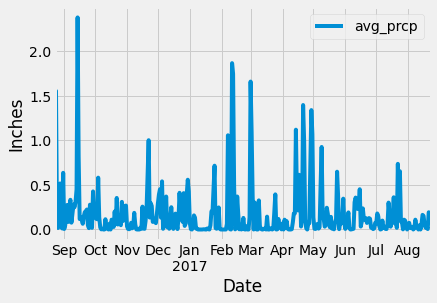

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
query = f'''
        select 
            date,
            avg(prcp) as avg_prcp
        from measurement 
        where 
            date >= (Select DATE(MAX(date),'-1 year') FROM measurement)
        group by
            date
        order by 
            date
        '''

# Save the query results as a Pandas DataFrame and set the index to the date column
recent_year_precip_data = pd.read_sql(query, conn)
recent_year_precip_data.head()

recent_year_precip_data['date'] = pd.to_datetime(recent_year_precip_data['date'])

# Convert the data column to date
recent_year_precip_data = recent_year_precip_data.set_index('date')

# Sort the dataframe by date
recent_year_precip_data = recent_year_precip_data.sort_values('date')
recent_year_precip_data.head()

# Use Pandas Plotting with Matplotlib to plot the data
recent_year_precip_data.plot()
plt.xlabel('Date')
plt.ylabel('Inches')

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
recent_year_precip_data.describe()

,avg_prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [11]:
# Design a query to show how many stations are available in this dataset?
query = '''
        select distinct station
        from measurement
        '''
stations_df = pd.read_sql(query, conn)

station_count = stations_df['station'].count()
print(f'There are {station_count} stations in the database')

There are 9 stations in the database


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
        select distinct 
            station,
            count(station) as station_count
        from 
            measurement 
        group by 
            station
        order by 
            station_count desc
        '''
most_active_stations_df = pd.read_sql(query, conn)
most_active_stations_df

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query = f'''
        select 
            station,
            count(station) as station_count,
            min(tobs) as lowest_temperature,
            max(tobs) as highest_temperature,
            avg(tobs) as avg_tobs
        from 
            measurement 
        group by 
            station
        order by 
            station_count desc
        limit 1
        '''

most_active_station_df = pd.read_sql(query, conn)
most_active_station_df

most_active_station = most_active_station_df['station'].values[0]
most_active_station

'USC00519281'

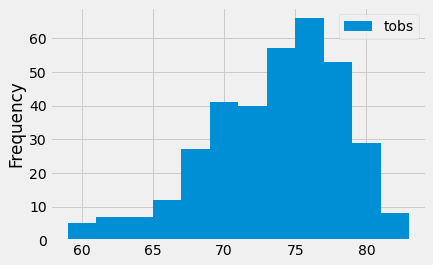

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = f'''
        select
            date,
            tobs
        from 
            measurement 
        where 
            date >= (Select DATE(MAX(date),'-1 year') FROM measurement)
            and station = '{most_active_station}'
        order by 
            date
        '''
    
most_tobs = pd.read_sql(query, conn) 
most_tobs.head()

most_tobs.plot.hist(bins = 12)


## Part 3 - Data Analysis Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
            select
                min(tobs) as lowest_temperature,
                max(tobs) as highest_temperature,
                avg(tobs) as avg_tobs
            from 
                measurement 
            where 
                date between '{start_date}' and '{end_date}'
            '''
    
    temp_stats_df = pd.read_sql(query, conn)
    
    temp_stats = tuple(temp_stats_df.values[0])
    
    return temp_stats

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


(62.0, 74.0, 69.57142857142857)


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-08-05', '2017-08-15')


(70.0, 84.0, 79.13333333333334)

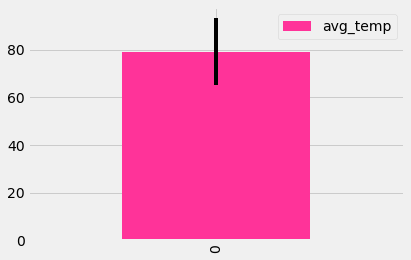

In [17]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_temps = {'lowest_temp': [calc_temps('2017-08-05', '2017-08-15')[0]],
                 'highest_temp': [calc_temps('2017-08-05', '2017-08-15')[1]],
                 'avg_temp': [calc_temps('2017-08-05', '2017-08-15')[2]]}
my_trip_temps_df = pd.DataFrame(my_trip_temps)
my_trip_temps_df

error = my_trip_temps_df['highest_temp'].sub(my_trip_temps_df['lowest_temp'])
my_trip_temps_df.plot.bar(y='avg_temp',yerr=error, color='#ff3399')

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = f'''
        SELECT
            m.station,
            name,
            date,
            sum(prcp) as total_precipitation,
            latitude,
            longitude,
            elevation
        FROM
            measurement as m
        inner JOIN
            station as s
        on 
            m.station = s.station
        WHERE
            date between '2017-08-05' and '2017-08-15'
        group by 
            date,
            m.station
        order by 
            sum(prcp) desc
        '''
    
total_precip = pd.read_sql(query, conn) 
total_precip.head()


,station,name,date,total_precipitation,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",2017-08-15,0.42,21.33310,-157.80250,152.4
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",2017-08-08,0.34,21.33310,-157.80250,152.4
2,USC00519281,"WAIHEE 837.5, HI US",2017-08-15,0.32,21.45167,-157.84889,32.9
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",2017-08-14,0.22,21.33310,-157.80250,152.4
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2017-08-09,0.15,21.33310,-157.80250,152.4


In [19]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    query = f'''
            SELECT	
                min(tobs) as lowest_temperature,
                max(tobs) as highest_temperature,
                avg(tobs) as avg_temperature
            FROM
                measurement
            WHERE
                date like '%%%%-{date}'
            '''
    
    target_date_daily_normals_df = pd.read_sql(query, conn)
    
    target_date_daily_normals = tuple(target_date_daily_normals_df.values[0])
    
    return target_date_daily_normals
    
daily_normals("08-11")


(67.0, 82.0, 75.98113207547169)

In [39]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

normals = []

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    query = f'''
            SELECT	
                min(tobs) as lowest_temperature,
                max(tobs) as highest_temperature,
                avg(tobs) as avg_temperature
            FROM
                measurement
            WHERE
                date like '%%%%-{date}'
            '''
    
    my_trip_daily_normals_df = pd.read_sql(query, conn)
    
    my_trip_daily_normals = tuple(my_trip_daily_normals_df.values[0])
    
    normals.append(my_trip_daily_normals)
    
    return my_trip_daily_normals

# Set the start and end date of the trip
start_date = '2020-08-05'
end_date = '2020-08-15'

# Use the start and end date to create a range of dates
trip_dates = ["2020-08-05", "2020-08-06", "2020-08-07", "2020-08-08", "2020-08-09", "2020-08-10", "2020-08-11", "2020-08-12", "2020-08-13", "2020-08-14", "2020-08-15"]

# convert strings to datetime
date_list =[datetime.strptime(date, "%Y-%m-%d") for date in trip_dates]
date_list

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in date_list]
dates


# Loop through the list of %m-%d strings and calculate the normals for each date

for date in dates:
    print(date)
    daily_normals(date)
        
print(normals)

08-05
08-06
08-07
08-08
08-09
08-10
08-11
08-12
08-13
08-14
08-15
[(69.0, 82.0, 76.14814814814815), (67.0, 83.0, 76.25), (71.0, 83.0, 77.15686274509804), (68.0, 83.0, 76.5576923076923), (69.0, 81.0, 75.98039215686275), (65.0, 83.0, 76.42), (67.0, 82.0, 75.98113207547169), (67.0, 83.0, 76.52727272727273), (71.0, 84.0, 76.98245614035088), (71.0, 82.0, 76.77777777777777), (69.0, 83.0, 76.47169811320755)]


In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=["tmin","tavg", "tmax"], index=trip_dates)
normals_df.index.name="date"
normals_df

,tmin,tavg,tmax
date,,,
2020-08-05,69.0,82.0,76.148148
2020-08-06,67.0,83.0,76.250000
2020-08-07,71.0,83.0,77.156863
2020-08-08,68.0,83.0,76.557692
2020-08-09,69.0,81.0,75.980392
2020-08-10,65.0,83.0,76.420000
2020-08-11,67.0,82.0,75.981132
2020-08-12,67.0,83.0,76.527273
2020-08-13,71.0,84.0,76.982456


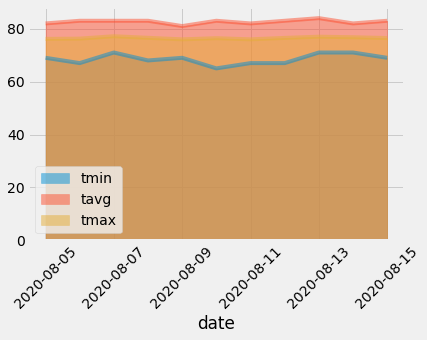

In [41]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()